In [1]:
from google.colab import drive
import os

drive.mount('/content/GoogleDrive', force_remount=True)
path = '/content/GoogleDrive/My Drive/ABSA'
os.chdir(path)
!ls

Mounted at /content/GoogleDrive
cc.vi.300.bin	     model_absa_v1.ipynb  VnCoreNLP
data		     model_absa_v2.ipynb  VnCoreNLP-1.1.1.jar
hs_err_pid60807.log  model_plot.png	  VnCoreNLP-1.2.jar
model		     preprocess.py	  wordsegmenter.rdr.txt
model_absa.ipynb     vi-vocab


## Import Libs

In [2]:
!pip install -q transformers
!pip install -q tf-models-official
!pip install py_vncorenlp vncorenlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [3]:
import numpy as np
import re
from gensim.utils import simple_preprocess
import pandas as pd
from nltk import flatten
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from tensorflow.train import CheckpointOptions
from tensorflow.data import Dataset
from transformers import TFAutoModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
import pickle 

## Connect TPU

In [4]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # tìm thông tin TPU
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

## Load Data

In [5]:
with open('./data/VLSP2018-SA-Restaurant-train.txt','r', encoding="utf8") as file:
    train = file.readlines()
with open('./data/VLSP2018-SA-Restaurant-dev.txt','r', encoding="utf8") as file:
    val = file.readlines()
with open('./data/VLSP2018-SA-Restaurant-test.txt','r', encoding="utf8") as file:
    test = file.readlines()

In [6]:
train[:10]

['\ufeff#1\n',
 '_ Ảnh chụp từ hôm qua, đi chơi với gia đình và 1 nhà họ hàng đang sống tại Sài Gòn. _ Hôm qua đi ăn trưa muộn, ai cũng đói hết nên lúc có đồ ăn là nhào vô ăn liền, bởi vậy mới quên chụp các phần gọi thêm với nước mắm, chỉ chụp món chính thôi! _ Đói quá nên không biết đánh giá đồ ăn kiểu gì luôn 😅😅😅_ Chọn cái này vì thấy nó lạ với tui.\n',
 '{FOOD#STYLE&OPTIONS, neutral}, {FOOD#QUALITY, neutral}\n',
 '\n',
 '#2\n',
 '_Hương vị thơm ngon, ăn cay cay rất thích, nêm nếm vừa miệng. Ngoài ra menu quán cũng nhiều món khác nhau tha hồ cho bạn lựa chọn luôn._Quán rộng rãi, view khá đẹp và cũng thoáng lắm. Khách của quán đông nên nhiều khi nhân viên phục vụ không được nhanh cho lắm._Thịt heo rừng giá theo kì nên nhớ hỏi trước nhưng trung bình là 150k 1 phần. Hai bạn đi chung chi khoảng 400k hơn là ổn nhé.\n',
 '{FOOD#QUALITY, positive}, {FOOD#STYLE&OPTIONS, positive}, {AMBIENCE#GENERAL, positive}, {RESTAURANT#GENERAL, positive}, {SERVICE#GENERAL, negative}, {FOOD#PRICES, neutral

### Xử lý dữ liệu

In [7]:
def get_data(data):
    get = 1
    review = []
    label = []
    for text in data:
        if get == 2:
            review.append(text)
            get+=1
        elif get == 3:
            label.append(text)
            get+=1
        elif get == 4:
            get=1
        else: get+=1
    return review,label

In [8]:
train_review, train_label = get_data(train)
val_review, val_label = get_data(val)
test_review, test_label = get_data(test)

In [9]:
train_review[:1]

['_ Ảnh chụp từ hôm qua, đi chơi với gia đình và 1 nhà họ hàng đang sống tại Sài Gòn. _ Hôm qua đi ăn trưa muộn, ai cũng đói hết nên lúc có đồ ăn là nhào vô ăn liền, bởi vậy mới quên chụp các phần gọi thêm với nước mắm, chỉ chụp món chính thôi! _ Đói quá nên không biết đánh giá đồ ăn kiểu gì luôn 😅😅😅_ Chọn cái này vì thấy nó lạ với tui.\n']

In [10]:
train_label[:1]

['{FOOD#STYLE&OPTIONS, neutral}, {FOOD#QUALITY, neutral}\n']

In [11]:
Aspect = ['AMBIENCE#GENERAL',	'DRINKS#PRICES',	'DRINKS#QUALITY',	'DRINKS#STYLE&OPTIONS',	'FOOD#PRICES',	'FOOD#QUALITY',	'FOOD#STYLE&OPTIONS',
          	'LOCATION#GENERAL',	'RESTAURANT#GENERAL',	'RESTAURANT#MISCELLANEOUS',	'RESTAURANT#PRICES',	'SERVICE#GENERAL']
pos = [1,0,0]
neg = [0,1,0]
neu = [0,0,1]
none = [0,0,0]
sentiments = ['positive','negative','neutral']

In [67]:
def get_aspect_label(data_label):
    aspect_label = []
    for i in data_label:
        aspect_text = []
        for j in Aspect:
            if j in i:
                if sentiments[0] in i:
                    aspect_text.append(pos)
                elif sentiments[1] in i:
                    aspect_text.append(neg)
                elif sentiments[2] in i:
                    aspect_text.append(neu)
            elif j not in i:
                aspect_text.append(none)
        aspect_label+= aspect_text
 
    return np.array(aspect_label, dtype='uint8')

In [62]:
aspect_label_train = get_aspect_label(train_label)
aspect_label_dev = get_aspect_label(val_label)
aspect_label_test = get_aspect_label(test_label)

In [63]:
def get_sentiment_label(label):
  sentiment_label = []
  for i in label:
    temp_list = [0 for i in range(len(Aspect)*3)]
    for k in i.split('}, '):
      sentiment_text = []
      for j in Aspect:
        if j in k:
          if sentiments[0] in k:
            sentiment_text+=pos
          if sentiments[1] in k:
            sentiment_text+=neg
          if sentiments[2] in k:
            sentiment_text+= neu
        if j not in k:
          sentiment_text+= none
      temp_list = [temp_list[index] + sentiment_text[index] for index in range(len(Aspect)*3)]
    sentiment_label.append(temp_list)
  return sentiment_label

In [64]:
sentiment_label_train = get_sentiment_label(train_label)
sentiment_label_dev =  get_sentiment_label(val_label)
sentiment_label_test =  get_sentiment_label(test_label)

In [66]:
sentiment_label_train[:1]

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]]

In [12]:
# def get_aspect_label(data_label):
#     aspect_label = []
#     for i in data_label:
#         aspect_text = []
#         for j in Aspect:
#             if j in i:
#                 if sentiments[0] in i:
#                     aspect_text.append(pos)
#                 elif sentiments[1] in i:
#                     aspect_text.append(neg)
#                 elif sentiments[2] in i:
#                     aspect_text.append(neu)
#             elif j not in i:
#                 aspect_text.append(none)
#         aspect_label.append(aspect_text)
 
#     return np.array(aspect_label, dtype='uint8')

In [68]:
y_train = get_aspect_label(train_label)
y_val = get_aspect_label(val_label)
y_test = get_aspect_label(test_label)

In [69]:
print('Train outputs:', y_train.shape)
print('Validate outputs:', y_val.shape)
print('Test outputs:', y_test.shape)
y_train[:2]

Train outputs: (35532, 3)
Validate outputs: (15480, 3)
Test outputs: (6000, 3)


array([[0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [15]:
# def get_aspect_label(label):
#   aspect_label = []
#   for i in label:
#     aspect_text = []
#     for j in Aspect:
#       if j in i:
#         aspect_text.append(1)
#       if j not in i:
#         aspect_text.append(0)
#     aspect_label.append(aspect_text)
 
#   return aspect_label

In [16]:
# def get_sentiment_label(data_label):
#     sentiment_label = []
#     for i in data_label:
#         sentiment_text = []
#         for j in Aspect:
#             if j in i:
#                 if sentiments[0] in i:
#                     sentiment_text.append(1)
#                 elif sentiments[1] in i:
#                     sentiment_text.append(2)
#                 elif sentiments[2] in i:
#                     sentiment_text.append(3)
#             else:
#                 sentiment_text.append(0)
#         sentiment_label.append(sentiment_text)
#     return sentiment_label

In [17]:
# sentiment_label_train = get_sentiment_label(train_label)
# sentiment_label_val = get_sentiment_label(val_label)
# sentiment_label_test = get_sentiment_label(test_label)

In [18]:
# df_train = pd.DataFrame(sentiment_label_train, columns = Aspect)
# df_val = pd.DataFrame(sentiment_label_val, columns = Aspect)
# df_test = pd.DataFrame(sentiment_label_test, columns = Aspect)
# df_train

In [19]:
# def make_outputs(df):
#     outputs = []
#     for row in range(len(df)):
#         row_one_hot = []
#         for col in range(0, len(df.columns)):
#             sentiment = df.iloc[row, col]
#             if   sentiment == 0: one_hot = [1, 0, 0, 0] # None
#             elif sentiment == 1: one_hot = [0, 1, 0, 0] # Pos
#             elif sentiment == 2: one_hot = [0, 0, 1, 0] # Neg
#             elif sentiment == 3: one_hot = [0, 0, 0, 1] # Neu
#             row_one_hot.append(one_hot)
#         outputs.append(row_one_hot)
#     return np.array(outputs, dtype='uint8')

In [20]:
# y_train = get_aspect_label(train_label)
# y_val = get_aspect_label(val_label)
# y_test = get_aspect_label(test_label)

In [21]:
# y_train = make_outputs(df_train)
# y_val = make_outputs(df_val)
# y_test = make_outputs(df_test)

# print('Train outputs:', y_train.shape)
# print('Validate outputs:', y_val.shape)
# print('Test outputs:', y_test.shape)
# y_train[0]

In [24]:
from vncorenlp import VnCoreNLP
tokenizer = VnCoreNLP('VnCoreNLP/VnCoreNLP-1.1.1.jar', annotators= 'wseg', max_heap_size = '-Xmx500m')

In [26]:
VN_CHARS_LOWER = u'ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđð'
VN_CHARS_UPPER = u'ẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸÐĐ'
VN_CHARS = VN_CHARS_LOWER + VN_CHARS_UPPER
def no_marks(s):
    __INTAB = [ch for ch in VN_CHARS]
    __OUTTAB = "a"*17 + "o"*17 + "e"*11 + "u"*11 + "i"*5 + "y"*5 + "d"*2
    __OUTTAB += "A"*17 + "O"*17 + "E"*11 + "U"*11 + "I"*5 + "Y"*5 + "D"*2
    __r = re.compile("|".join(__INTAB))
    __replaces_dict = dict(zip(__INTAB, __OUTTAB))
    result = __r.sub(lambda m: __replaces_dict[m.group(0)], s)
    return result

In [27]:
replace_list = pickle.load(open(f'{path}/data/replace.pkl','rb'))
pickle.dump(replace_list,open(f'{path}/data/replace.pkl','wb'))

In [28]:
def text_preprocess(text):
    check = re.search(r'([a-z])\1+',text)
    if check:
          if len(check.group())>2:
            text = re.sub(r'([a-z])\1+', lambda m: m.group(1), text, flags=re.IGNORECASE) #remove các ký tự kéo dài như hayyy, ngonnnn...

          text = text.strip() #loại dấu cách đầu câu
        
          for k, v in replace_list.items():       #replace các từ có trong replace_list
            text = text.replace(k, v)       
          text = re.sub('[!”"#$%&’()•/:;<=>-?@[\]^`{|}~+*_-]', ' ', text) #special character
          text = re.sub('\d+k', '', text) #300k, 200k 
          text = re.sub('\d+', '', text) #number
          text = re.sub('(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b', ' ', text) #web address
          text = re.sub('www\.\S+\.com', ' ', text) #web address
          text = re.sub('@\S+', ' ', text) #user mention
          text = re.sub('[0-9]k', ' ', text)
          emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
          text = re.sub(emoji_pattern, '', text)
          
          text = ' '.join(i for i in flatten(tokenizer.tokenize(text)))
          text = text.lower() 
    return text

In [29]:
def preprocess(data):
    token = []
    token_nomarks = []
    for text in data:
        check = re.search(r'([a-z])\1+',text)
        if check:
          if len(check.group())>2:
            text = re.sub(r'([a-z])\1+', lambda m: m.group(1), text, flags=re.IGNORECASE) #remove các ký tự kéo dài như hayyy, ngonnnn...

        text = text.strip() #loại dấu cách đầu câu
      
        for k, v in replace_list.items():       #replace các từ có trong replace_list
          text = text.replace(k, v)       
        text = re.sub('[!”"#$%&’()•/:;<=>-?@[\]^`{|}~+*_-]', ' ', text) #special character
        text = re.sub('\d+k', '', text) #300k, 200k 
        text = re.sub('\d+', '', text) #number
        text = re.sub('(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b', ' ', text) #web address
        text = re.sub('www\.\S+\.com', ' ', text) #web address
        text = re.sub('@\S+', ' ', text) #user mention
        text = re.sub('[0-9]k', ' ', text)
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text = re.sub(emoji_pattern, '', text)
        
        text = ' '.join(i for i in flatten(tokenizer.tokenize(text)))
        text = text.lower()             
        text_nomarks = token_nomarks.append(no_marks(text))
        token.append(text)
    return token, token_nomarks

In [30]:
len(train_review)

2961

In [31]:
train_review, train_review1  = preprocess(train_review)
train_review += train_review1
val_review, val_review1 = preprocess(val_review)
val_review += val_review1
test_review, test_review1 = preprocess(test_review)
test_review += test_review1

In [32]:
train_review[0]

'ảnh chụp từ hôm_qua , đi chơi với gia_đình và nhà họ_hàng đang sống tại sài_gòn . hôm_qua đi ăn trưa muộn , ai cũng đói hết nên lúc có đồ_ăn là nhào vô ăn_liền , bởi_vậy mới quên chụp các phần gọi thêm với nước_mắm , chỉ chụp món chính thôi đói quá nên không biết đánh_giá đồ_ăn kiểu gì luôn chọn cái này vì thấy nó lạ với tui .'

In [70]:
y_train = np.concatenate((y_train, y_train), axis=0)
y_val = np.concatenate((y_val, y_val), axis=0)
y_test = np.concatenate((y_test, y_test), axis=0)

In [71]:
len(y_train)

71064

In [72]:
y_train[:2]


array([[0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [36]:
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

In [37]:
encode = Tokenizer()

In [38]:
encode.fit_on_texts(train_review)

In [39]:
encode.fit_on_texts(val_review)
encode.fit_on_texts(test_review)

In [40]:
train_review = encode.texts_to_sequences(train_review)

In [41]:
val_review = encode.texts_to_sequences(val_review)
test_review = encode.texts_to_sequences(test_review )


In [42]:
def pad_sequences_data(maxlen, tokenizer, X_train, X_val, X_test):
  word_index = tokenizer.word_index
  vocab_size = len(word_index) + 1 

  X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
  X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
  X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

  return X_train, X_val, X_test, word_index, vocab_size

In [43]:
import numpy as np

def get_embedding(word_index, embedding_model, embedding_dim = 300):
  error = []
  embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
  for word, i in word_index.items():
      try:
        embedding_vector = embedding_model[word]
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
      except:
        error.append(word)
        pass
  return embedding_matrix, error

In [44]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [73]:
#@title GET_MODEL
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, Input
from keras.layers import LSTM, Bidirectional
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import Adam
def get_model(max_feature, max_output_length, embedding_matrix, vocab_size, embedding_dim=300, aspect_only=False):
    sequence_input = Input(shape=(max_feature,), dtype='int32')

    embedding_layer = Embedding(vocab_size,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_feature,
                                trainable=False)

    embedded_sequences = embedding_layer(sequence_input)
    conv1 = Conv1D(256, 3, activation='relu', padding='same')(embedded_sequences)
    conv1 = MaxPooling1D()(conv1)
    conv1 = Dropout(0.5)(conv1)

    conv2 = Conv1D(128, 3, activation='relu', padding='same')(conv1)
    conv2 = MaxPooling1D()(conv2)
    conv2 = Dropout(0.5)(conv2)

    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(conv2)
    lstm2 = Bidirectional(LSTM(64))(lstm1)

    x = Dense(max_feature, activation='relu')(lstm2)

    _activation = 'sigmoid' if aspect_only else 'tanh'
    _loss = 'mse' if aspect_only else 'categorical_crossentropy'
    _metrics = [f1] if aspect_only else [f1]

    output = Dense(max_feature, activation=_activation)(x)
    model = Model(sequence_input, output)
    model.compile(loss=_loss,
                  optimizer=Adam(lr=0.0001),
                  metrics=_metrics)
    return model

In [46]:
#@title OUTPUT_ACTIVATION_FUNCTION
def vinh_activation(result):
  x = result
  if(x < 0 and x < -0.5):
    return -1
  if(x < 0 and x >= -0.5):
    return -0.5
  if(x > 0 and x > 0.5):
    return 1
  if(x > 0 and x <= 0.5):
    return 0.5
  return x

In [47]:
def average_len(l):
  return sum(map(len, l))/float(len(l))

In [48]:
import glob
global files_restaurant
global files_hotel
files_restaurant = glob.glob("data_restaurant/*.csv")
files_hotel = glob.glob("data_hotel/*.csv")

In [49]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393451 sha256=f771c96a085de854653b9bdc6d2161c9acaa7654a4dbaac57ca1b99960e667c6
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [50]:
import fasttext

In [51]:
# Load the FastText model
embedding_model = fasttext.load_model(f'{path}/cc.vi.300.bin')

In [52]:
print(str.format('train: {}\ndev: {}\ntest:{}',average_len(train_review), average_len(val_review), average_len(test_review)))

train: 54.11854103343465
dev: 49.58217054263566
test:168.198


In [53]:
X_train, X_val, X_test,  word_index_restaurant, vocab_size_restaurant = pad_sequences_data(48, encode, train_review, val_review, test_review)

In [54]:
X_train[:3]

array([[  44,  351,    9,  175,    3,    8, 3650,  428,    3,  852, 1347,
         376,  198,  927,  936,  134,  142,  188,  116,   63,   32,  315,
         145,  936,   46,  762,  180, 1076,  103,   44,    7,  336, 1081,
          66,  175,    3,  403,  282,   57,  476,  140,   39,  238,   84,
         477,  347,   63,  505],
       [ 937,   69,  455,   19,   13,  560,   72,  299,  150,   15,  234,
          44,   65,  155,  158,  152,  220,  208,    7,   64,  193,   10,
          72,   60,  337, 2114,   66,  217,  604,   44,  596,  831,  459,
          51,  104,  269,    8,  142,  270,  108,   92,  115,   74,  555,
         159,    8,  457,  250],
       [1687,   38,   66,  145,    3,  104, 1800, 1135,   17,  130,  239,
        2580,  605,   63,  128,  179,  456,  403,  605,   57,   15,  262,
          43,  709,  624,   38,  386,  220,  208,   56,  332,  550,  718,
         971,  308, 1136,  361, 1092, 3652, 1801,  123,   91,    9,  338,
         587,  612,  406,  258]], dtype=int32)

In [55]:
embedding_matrix_restaurant, error_restaurant = get_embedding(word_index_restaurant, embedding_model)

In [56]:
# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix_restaurant, axis=1))
print(nonzero_elements / vocab_size_restaurant)   

0.9987041036717063


In [57]:
#@title GET_MODEL
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, Input
from keras.layers import LSTM, Bidirectional
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import Adam

def get_model(max_feature, max_output_length, embedding_matrix, vocab_size, embedding_dim=300, aspect_only=False):
    sequence_input = Input(shape=(max_feature,), dtype='int32')

    embedding_layer = Embedding(vocab_size,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_feature,
                                trainable=False)

    embedded_sequences = embedding_layer(sequence_input)
    conv1 = Conv1D(256, 3, activation='relu', padding='same')(embedded_sequences)
    conv1 = MaxPooling1D()(conv1)
    conv1 = Dropout(0.5)(conv1)

    conv2 = Conv1D(128, 3, activation='relu', padding='same')(conv1)
    conv2 = MaxPooling1D()(conv2)
    conv2 = Dropout(0.5)(conv2)

    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(conv2)
    lstm2 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)  # Return sequences

    x = Dense(64, activation='relu')(lstm2)

    _activation = 'sigmoid' if  aspect_only else 'tanh'
    _loss = 'mse' if  aspect_only else 'categorical_crossentropy'
    _metrics = [f1] if aspect_only else [f1]

    output = Dense(3, activation=_activation)(x)  # Output shape (None, 12, 3)
    model = Model(sequence_input, output)
    model.compile(loss=_loss,
                  optimizer=Adam(lr=0.0001),
                  metrics=_metrics)
    return model

In [74]:
#for aspect only
model_cnn_lstm = get_model(len(X_train[0]), len(y_train[0]), embedding_matrix_restaurant, vocab_size_restaurant)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


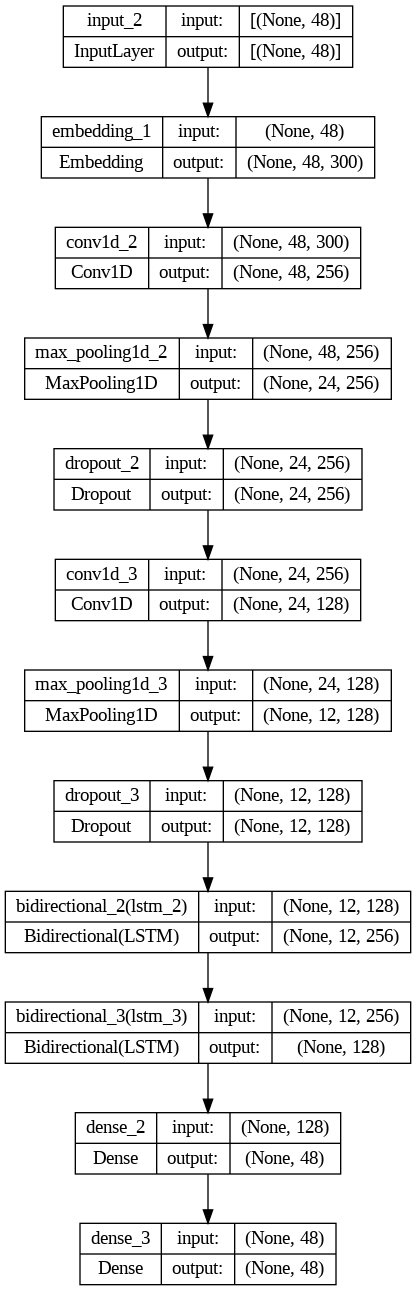

In [75]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn_lstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [76]:
batch_size = 50
epochs = 10
cnn_lstm = model_cnn_lstm.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val, y_val))

ValueError: ignored

In [ ]:
y_pred = cnn_lstm.model.predict(X_test)

In [ ]:
from keras.models import load_model
cnn_lstm.model.save('domain_restaurant.h5')

In [ ]:
import keras
from matplotlib import pyplot as plt

plt.plot(cnn_lstm.history['f1'])
plt.plot(cnn_lstm.history['val_f1'])

plt.title('F1 score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(cnn_lstm.history['loss'])
plt.plot(cnn_lstm.history['val_loss'])

plt.title('Loss value')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def print_result(items, columns):
  result = []
  for i in range(len(items)):
    if(items[i] != -0.5):
      if(items[i] == -1):
        result.append([columns[i], 'negative'])
      elif(items[i] == 1):
        result.append([columns[i], 'positive'])
      else:
        result.append([columns[i], 'neutral'])
    else:
      pass
  return result

In [ ]:
from keras.models import load_model
dependencies = {
    'f1': f1
}

In [ ]:
pretrain =  load_model('domain_restaurant.h5', custom_objects=dependencies)

In [ ]:
pretrain.evaluate(X_val, y_val)

In [ ]:
#sample = d_dev_restaurant.iloc[:10,:]
sample_pad = X_val[:10]

In [ ]:
y_pred = pretrain.predict(sample_pad)

In [ ]:
type(Aspect)

In [ ]:
columns = Aspect.tolist()

In [ ]:
print_result(y_pred[5], Aspect)